In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import yaml

import torch

from data_helpers import plot_photons_histograms
from DDPM_lit import DDPM_lit

In [2]:
with open("ddpm_config.yaml", 'r') as file:
    config = yaml.safe_load(file)

checkpt_path = config['checkpoint_params']['dirpath']
model = DDPM_lit.load_from_checkpoint(f"{checkpt_path}/ddpm_epoch=399_train_loss=0.055821.ckpt", config=config)
print(model)

0
1
DDPM_lit(
  (model): ConditionalModel(
    (lin1): ConditionalLinear(
      (lin): Linear(in_features=6, out_features=256, bias=True)
      (embed): Embedding(700, 256)
    )
    (lin2): ConditionalLinear(
      (lin): Linear(in_features=256, out_features=256, bias=True)
      (embed): Embedding(700, 256)
    )
    (lin3): Linear(in_features=256, out_features=6, bias=True)
  )
  (diffusion): GaussianDiffusion()
)


In [3]:
photons = np.load(f'{config["dataset_params"]["data_path"]}/{config["dataset_params"]["filename"]}')
device = torch.device("cuda:1")
num_photons = photons.shape[0]
batch_size = int(config["dataset_params"]["batch_size"])
iterations = int(num_photons/batch_size)
photons_generated = model(torch.Tensor(batch_size, 6).to(device))[-1]
for t in range(iterations-1):
    generated = model(torch.Tensor(batch_size, 6).to(device))[-1]
    photons_generated = torch.cat((photons_generated, generated))
    if t%100==0:
        print(f"Photons generated: {t*batch_size} / {iterations*batch_size}")

Photons generated: 0 / 9950000
Photons generated: 1000000 / 9950000
Photons generated: 2000000 / 9950000
Photons generated: 3000000 / 9950000
Photons generated: 4000000 / 9950000
Photons generated: 5000000 / 9950000
Photons generated: 6000000 / 9950000
Photons generated: 7000000 / 9950000
Photons generated: 8000000 / 9950000
Photons generated: 9000000 / 9950000


(9957622, 6)


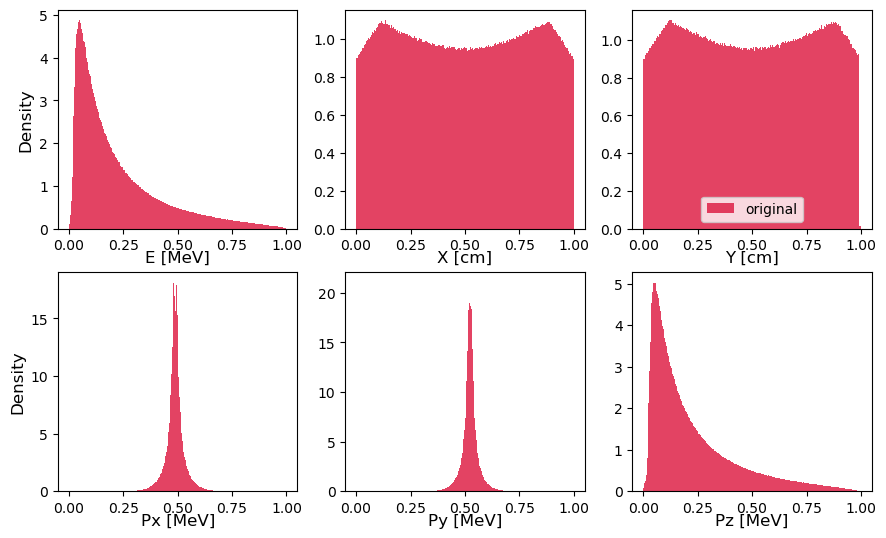

In [4]:
photons = np.load(f'{config["dataset_params"]["data_path"]}/photons_XYTE_E5.6_s0.0_a1.5.npy')
print(photons.shape)
mmsc = MinMaxScaler()
photons_mm = mmsc.fit_transform(photons)
figs, axs = plt.subplots(nrows=2, ncols=3, figsize=(10.5,6.25))
plot_photons_histograms(photons_mm, axs, figs, title='')

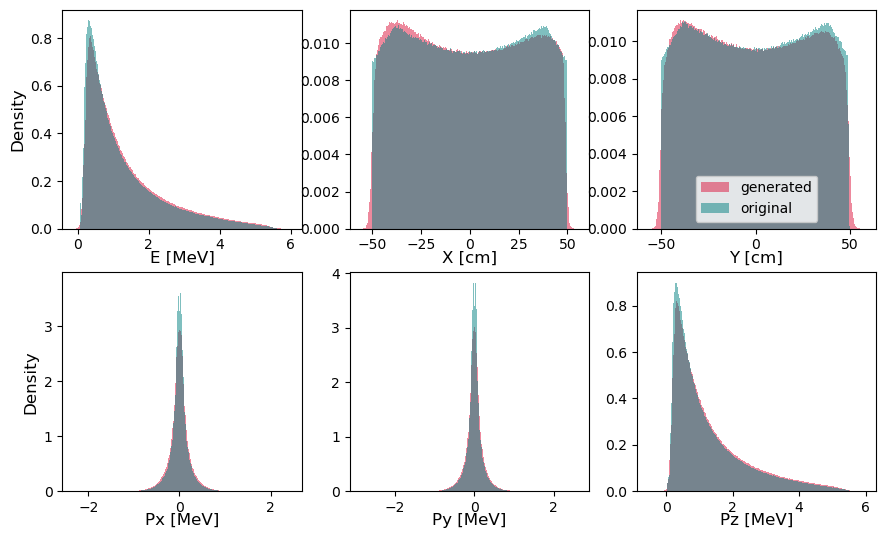

In [5]:
cur_x = photons_generated.detach()
inv_cur_x = mmsc.inverse_transform(cur_x.numpy())
figs, axs = plt.subplots(nrows=2, ncols=3, figsize=(10.5,6.25))
plot_photons_histograms(inv_cur_x, axs, figs, label='generated', a=0.5)
plot_photons_histograms(photons, axs, figs, data_color='teal', a=0.5)

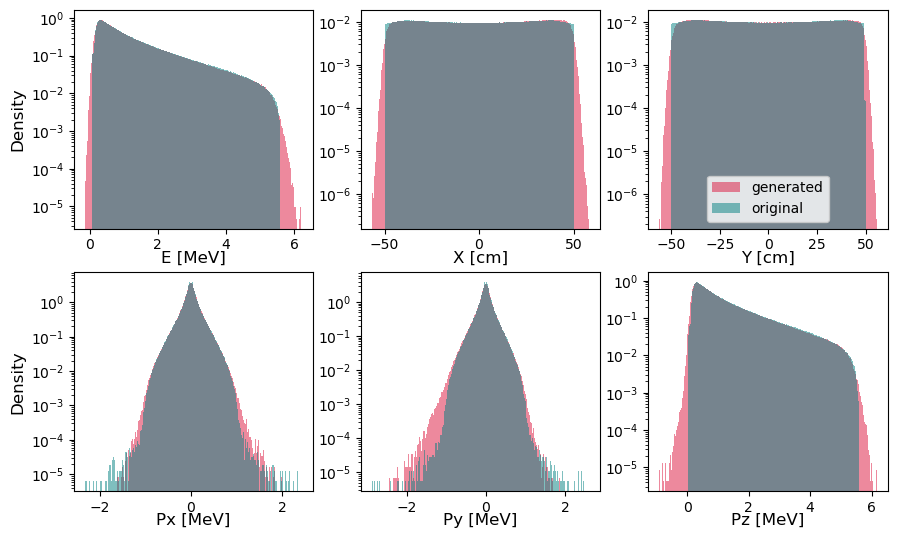

In [8]:
figs, axs = plt.subplots(nrows=2, ncols=3, figsize=(10.5,6.25))
plot_photons_histograms(inv_cur_x, axs, figs, log_ax=True, label='generated', a=0.5)
plot_photons_histograms(photons, axs, figs, log_ax=True, data_color='teal', a=0.5)

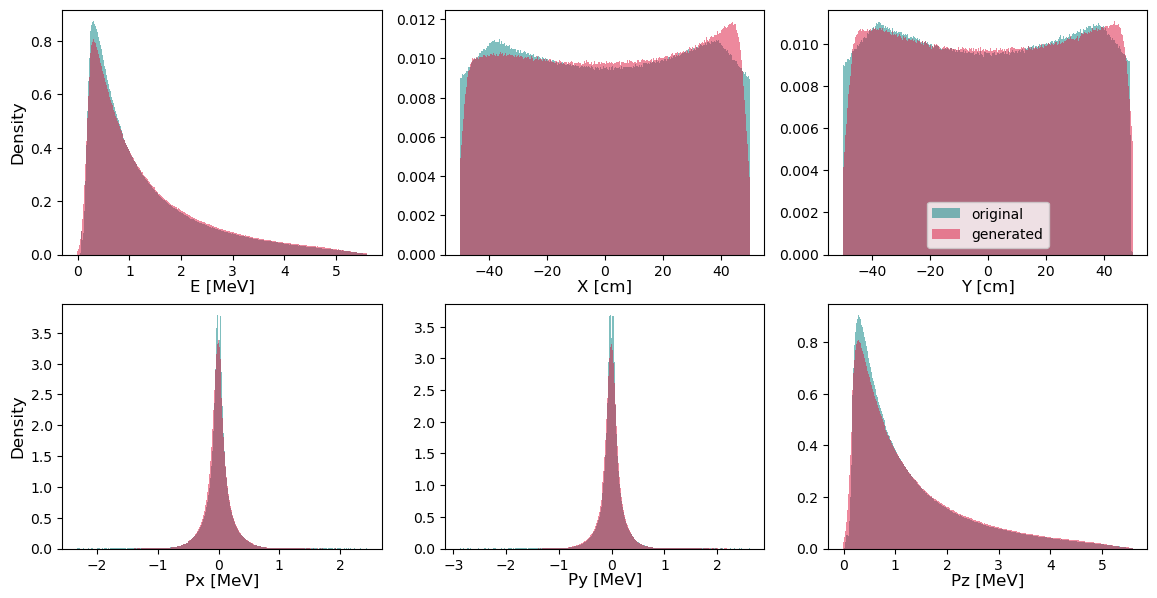

In [10]:
keys = ['E [MeV]', 'X [cm]', 'Y [cm]', 'Px [MeV]', 'Py [MeV]', 'Pz [MeV]']
fig, axs = plt.subplots(2, 3, figsize=(14,7))
original_bins = {}
generated_bins = {}
bins_edges_raw = {}

for i, j in enumerate(keys):
    mi=photons[:, i].min()
    ma=photons[:, i].max()
    bins_edges_raw[j] = np.linspace(mi, ma, 300)
    original_bins[j] = axs.flatten()[i].hist(photons[:, i], bins=bins_edges_raw[j], alpha=.5, color='teal', label='original', density=True)[0]
    generated_bins[j] = axs.flatten()[i].hist(inv_cur_x[:, i], bins=bins_edges_raw[j], alpha=.5, color='crimson', label='generated', density=True)[0]
    axs.flatten()[i].set_xlabel(f'{j}', fontsize=12)
    axs.flatten()[i].xaxis.set_label_coords(.5, -.1)
axs.flatten()[0].set_ylabel('Density', fontsize=12)
axs.flatten()[3].set_ylabel('Density', fontsize=12)
axs.flatten()[2].legend(loc='lower center')
plt.show()

/tmp/ipykernel_506062/855311558.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  reduced_residuum_raw[j] = [abs(gen-orig)/orig for gen, orig in zip(generated_bins[j], original_bins[j])]
/tmp/ipykernel_506062/855311558.py:5: RuntimeWarning: invalid value encountered in double_scalars
  reduced_residuum_raw[j] = [abs(gen-orig)/orig for gen, orig in zip(generated_bins[j], original_bins[j])]


Text(0, 0.5, 'Density/Relative Error')

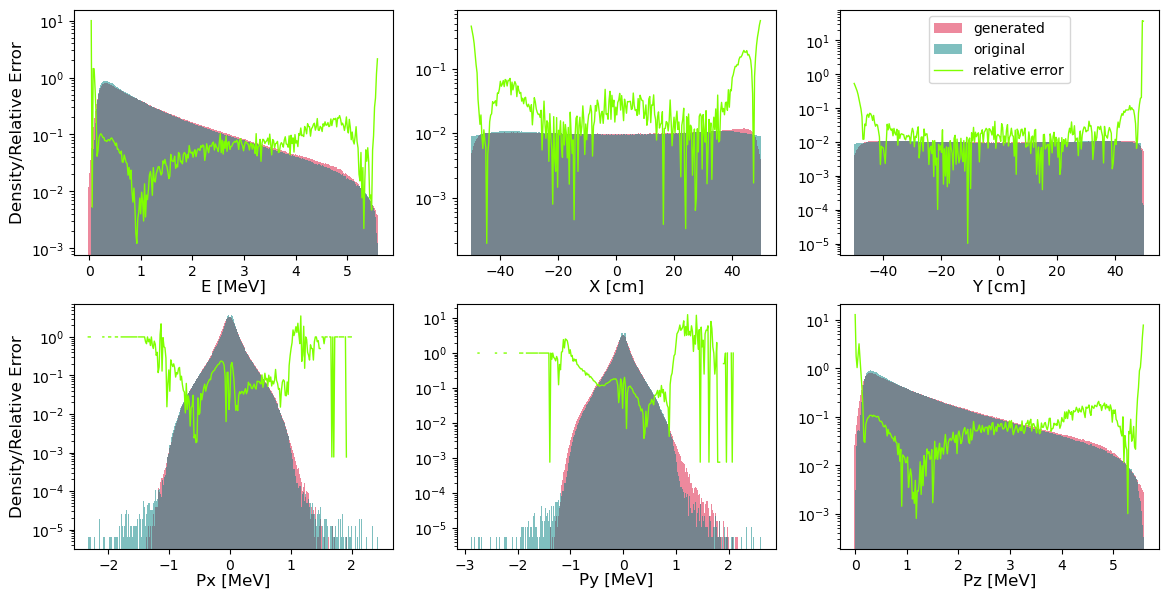

In [11]:
fig, axs = plt.subplots(2, 3, figsize=(14,7))
reduced_residuum_raw = {}

for i, j in enumerate(keys):
    reduced_residuum_raw[j] = [abs(gen-orig)/orig for gen, orig in zip(generated_bins[j], original_bins[j])]
    axs.flatten()[i].hist(inv_cur_x[:, i], bins=bins_edges_raw[j], alpha=.5, color='crimson', label='generated', density=True)
    axs.flatten()[i].hist(photons[:, i], bins=bins_edges_raw[j], alpha=.5, color='teal', label='original', density=True)
    axs.flatten()[i].plot(bins_edges_raw[j][:-1], reduced_residuum_raw[j], label='relative error', linewidth=1, color='chartreuse')
    axs.flatten()[i].set_yscale('log')
    axs.flatten()[i].set_xlabel(f'{j}', fontsize=12)
    axs.flatten()[i].xaxis.set_label_coords(.5, -.1)
axs.flatten()[2].legend(loc='upper center')
axs.flatten()[0].set_ylabel('Density/Relative Error', fontsize=12)
axs.flatten()[3].set_ylabel('Density/Relative Error', fontsize=12)

In [12]:
E_P_generated_raw = [inv_cur_x[i,0]**2 - (inv_cur_x[i,3]**2+inv_cur_x[i,4]**2+inv_cur_x[i,5]**2) for i in range(len(inv_cur_x[:,0]))]
E_P_original_raw = [photons[i,0]**2 - (photons[i,3]**2+photons[i,4]**2+photons[i,5]**2) for i in range(len(photons[:,0]))]
fig, axs = plt.subplots(ncols=2, figsize=(12,4))
axs[0].hist(E_P_generated_raw, bins=600, density=True, label='generated', color='crimson')
axs[1].hist(E_P_original_raw, bins=300, density=True, label='original', color='teal')
axs[0].set_title('generated')
axs[1].set_title('original')
axs[0].set_xlim(-1,1)
axs[0].set_xlabel('E^2-P^2 [MeV]', fontsize=12)
axs[1].set_xlabel('E^2-P^2 [MeV]', fontsize=12)
axs[0].set_ylabel('Density', fontsize=12)
axs[1].set_ylabel('Density', fontsize=12)
axs[0].text(0.1, 10, f'Mean = {np.mean(E_P_generated_raw):1.14f} \nStd Dev = {np.std(E_P_generated_raw):1.14f}', fontsize=8,
        bbox={'facecolor': 'crimson', 'alpha': 0.5, 'pad': 10})
axs[1].text(-0.00005, 6900, f'Mean = {np.mean(E_P_original_raw)} \nStd Dev = {np.std(E_P_original_raw):1.18f}', fontsize=8,
        bbox={'facecolor': 'teal', 'alpha': 0.5, 'pad': 10})

KeyboardInterrupt: 